In [1]:
# Importing packages
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays
from statsmodels.tsa.stattools import adfuller
import warnings
# Suppress all warnings
warnings.simplefilter("ignore")
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import zscore
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

# Loading data
df = pd.read_csv('initial_data2.csv')

# Converting Date column to Datetime object
df['Date'] = pd.to_datetime(df['Date'])

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Abstract - FINISH

Briefly summarize the objectives, methodologies, key findings, and the selected best-performing
model. Highlight the collaborative learning process among group members

# Project and Data Overview

## Project Overview - FINISH

Our goal for the project was to use time series prediction to predict the percent of people in the United States who have completed the primary series of Covid-19 vaccinations and received the first booster dose. Our dataset was taken from the Centers for Disease Control and Prevention (CDC). The observations occur at the state level, with each state reporting Covid-19 vaccination data daily starting in December 2020. The last date in the dataset is May 12th, 2023. The dataset also includes other variables that could play a significant role in predicting the percent of people who have completed a primary series of a vaccination and received a booster dose. 

Users that could benefit from the model may include vaccine companies, doctors, and the government. Accurate predictions of booster vaccine completion rates allow vaccine companies and government health agencies to plan and allocate resources effectively. This includes manufacturing, distribution, and administration resources. Vaccine companies can use the model to forecast the demand for booster vaccines and adjust production schedlues accordingly, manage inventory, and avoid wastage. Government health agencies can design targeted public health campaigns to encourage booster vaccination based on predicted completion rates. This involves tailoring communication strategies to address specific demographics, regions, or groups with lower predicted completion rates, thereby improving overall vaccination coverage. Doctors and healthcare providers can benefit from predictive models by efficiently allocating resources within healthcare facilities. Knowing when demand for booster vaccines is likely to peak allows for proper staffing, appointment scheduling, and the organization of vaccination clinics. Predicting vaccination completion rates can benefit many people and be used in multiple scenarios.

## Data Overview and Preprocessing

Once again, the data from the dataset that we used was collected by the Centers for Disease Control and Prevention (CDC). The data is made accessible through the CDC's Application Programming Interface (API). The observations occur at the state level, with each state reporting data every day from the start of the dataset until June 2022, then switching to weekly data until May 2023. Our predictor variable we are using is `Additional_Doses_Vax_Pct` in which we aim to predict the percent of people in the United States who have completed the primary series of Covid-19 vaccinations and received the first booster dose.

Before beginning the time series prediction, I will briefly introduce the data preprocessing steps we took on our dataset.

### Imputing missing values and removing redundant features

The goal for the project was the predict the percentage of the population in the United States that has received the initial booster. To start, we eliminated features with more than 1,000 missing values, as they relate to the bivalent booster or second booster distribution. The second booster was introduced about a year after the initial booster. To avoid data leakage, we ensured that data regarding the second booster doses are absent, given that these vaccines weren't available at the time of predicting our initial booster.

Columns existed for both the proportion of people in a state who had been vaccinated and the actual number who received the vaccine. Since these essentially measured the same metric, albeit at different scales, we felt it redundant. Hence, we discarded the count features and retained the proportion columns, ensuring consistent scaling across states.

Furthermore, a significant portion of data before November 2nd, 2021, was missing. Research revealed that this date aligned with the CDC’s recommendation for children aged five to eleven to receive the vaccine (Kates et al., 2021). This led us to adjust our dataset's starting point to this date for consistency. We observed a significant number of missing entries for December 14th, 2022. While the cause remains unclear, our research into time series imputation techniques led us to select the Last Observation Carried Forward (LOCF) method (Abulkhair, 2023). Consequently, we used the data from December 7th, 2022, to fill the gaps for those states with incomplete data on December 14th, 2022.

In [2]:
#### Data Preparation and Cleaning

# find na value counts
missing_counts = df.isna().sum()

# Sort the missing value counts in descending order
missing_counts_sorted = missing_counts.sort_values(ascending=False)

# columns with over 1000 missing values
columns_with_over_1000_missing = missing_counts_sorted[missing_counts_sorted > 1000].index

# remove columns with over 1000 missing
df = df.drop(columns=columns_with_over_1000_missing)

# list of numerical columns wihh equivalent percentage columns to drop
columns_to_drop = [
       'Administered_Dose1_Recip',   
       'Administered_Dose1_Recip_5Plus',
       'Administered_Dose1_Recip_12Plus',  
       'Administered_Dose1_Recip_18Plus',
       'Administered_Dose1_Recip_65Plus', 
        'Series_Complete_Yes',
        'Series_Complete_5Plus',
        'Series_Complete_12Plus',
        'Series_Complete_18Plus',
       'Series_Complete_65Plus',
       'Additional_Doses_18Plus', 
       'Additional_Doses_50Plus', 
       'Additional_Doses_65Plus']

# Dropping the columns from the df
df = df.drop(columns = columns_to_drop)

# Defining response variable for easier 
pred_var = 'Additional_Doses_Vax_Pct' 

given_date = pd.to_datetime('2021-11-02') 

df = df[df['Date'] > given_date]

specific_day = '2022-12-14'  

specific_day_data = df.loc[df['Date'] == specific_day]

rows_with_missing_values = specific_day_data[specific_day_data.isnull().any(axis=1)]


location_values = rows_with_missing_values['Location'].tolist()

# Month column
df['month'] = df['Date'].dt.month

# Year column
df['year'] = df['Date'].dt.year

# Filter the DataFrame for dates in December 2022
december_2022_data = df[(df['year'] == 2022) & (df['month'] == 12)]

for location in location_values:
    # Subset data for the specific location
    location_data = df[df['Location'] == location]
    
    # Subset data for the specific dates
    dates_to_impute = location_data[location_data['Date'].isin(['2022-12-07', '2022-12-14'])]
    
    # Perform forward fill (LOCF) imputation for the specific location and dates
    imputed_data = dates_to_impute.bfill()
    
    # Update the original DataFrame with the imputed data for the current location
    df.loc[imputed_data.index, imputed_data.columns] = imputed_data

### Temporal Aggregation:

Upon deeper data analysis, we discovered a shift in June 2022, where the API transitioned from daily to weekly reporting. To maintain consistency, we chose to resample our dataset to capture weekly observations every Wednesday, aligning with the reporting pattern post-June 2022.

In [3]:
june_2022_data = df[(df['year'] == 2022) & (df['month'] == 6)]

dec_2021_data = df[(df['year'] == 2021) & (df['month'] == 12)]

df['day_of_week'] = df['Date'].dt.day_name()

# Identifying day of week
given_date = pd.to_datetime('2022-06-22') 
days = df[df['Date'] > given_date]

df = df[df['day_of_week'] == 'Wednesday']

### Feature Engineering:

In our time-series analysis, we recognized the value of feature engineering to uncover potential predictors not explicitly present in the CDC’s API. Consequently, we integrated columns indicating the quarter, month, year, day of the week, day of the month, day of the year, and week of the year the observation was taken. Additionally, we established columns denoting the season of the observation (Winter, Spring, Fall, or Summer). We incorporated a Boolean column to indicate if the week of the observation encompassed a holiday, as per the `holidays` Python library, and another to denote if it contained a vaccine announcement by the CDC (Montel, 2017; Hahn, n.d.).

In [4]:
# Quarter column
df['quarter'] = df['Date'].dt.quarter

# Day of year column
df['dayofyear'] = df['Date'].dt.dayofyear

# Day of month column
df['dayofmonth'] = df['Date'].dt.day

# Week of year column
df['weekofyear'] = df['Date'].dt.isocalendar().week.astype(np.int64)

# Defining function to identify season
def get_season(date):
    month = date.month
    day = date.day
    if month in [3, 4, 5]:
        season = 'spring'
    elif month in [6, 7, 8]:
        season = 'summer'
    elif month in [9, 10, 11]:
        season = 'fall'
    else:
        season = 'winter'
    

    if month == 3 and day < 20:
        season = 'winter'
    elif month == 6 and day < 21:
        season = 'spring'
    elif month == 9 and day < 22:
        season = 'summer'
    elif month == 12 and day < 21:
        season = 'fall'
    
    return season

# Applying function and creating season column
df['season'] = df['Date'].apply(get_season)

# Create a list of US holidays for the given year range in the dataframe
us_holidays = holidays.US(years=[df['Date'].dt.year.min(), df['Date'].dt.year.max()]).keys()

# Convert us_holidays to a pandas Series of datetime objects
us_holidays_series = pd.Series(pd.to_datetime(list(us_holidays)))

# Create Holiday column
df['holidays'] = df['Date'].isin(us_holidays_series) | (df['Date'] + pd.Timedelta(days=1)).isin(us_holidays_series)
df['holidays'] = df['holidays'].replace({True: 'Holiday', False: 'Normal day'})

# Determine which weeks have a holiday
holiday_weeks = us_holidays_series.dt.strftime('%U-%Y').unique()

# Assign a "holiday season" for every date that's within a week having a holiday
df['holiday_season'] = df['Date'].dt.strftime('%U-%Y').isin(holiday_weeks)

In [5]:
# Define a list of unique announcement dates
announcement_dates = [
    "04/28/2023", "04/27/2023", "04/18/2023", "03/14/2023", "03/10/2023",
    "12/16/2022", "12/08/2022", "10/21/2022", "10/12/2022", "09/13/2022",
    "08/31/2022", "08/26/2022", "08/19/2022", "07/13/2022", "07/08/2022",
    "06/30/2022", "06/17/2022", "05/17/2022", "05/05/2022", "04/29/2022",
    "04/15/2022", "04/01/2022", "03/29/2022", "03/21/2022", "03/11/2022",
    "02/11/2022", "02/01/2022", "01/31/2022", "01/11/2022", "01/07/2022",
    "01/03/2022", "12/17/2021", "12/14/2021", "12/09/2021", "11/30/2021",
    "11/19/2021", "10/29/2021", "10/26/2021", "10/22/2021", "10/20/2021",
    "10/14/2021", "10/01/2021", "09/24/2021", "09/22/2021", "09/20/2021",
    "09/17/2021", "09/10/2021", "09/02/2021", "09/01/2021", "08/24/2021",
    "08/23/2021", "08/18/2021", "08/13/2021", "08/12/2021", "08/06/2021",
    "08/03/2021", "07/30/2021", "07/16/2021", "07/13/2021", "07/08/2021",
    "07/06/2021", "07/02/2021", "06/29/2021", "06/25/2021", "06/15/2021",
    "06/11/2021", "06/10/2021", "05/25/2021", "05/19/2021", "05/11/2021",
    "05/10/2021", "04/27/2021", "04/23/2021", "04/21/2021", "04/16/2021",
    "04/13/2021", "04/12/2021", "04/01/2021", "03/26/2021", "03/24/2021",
    "03/17/2021", "03/05/2021", "03/02/2021", "02/27/2021", "02/26/2021",
    "02/25/2021", "02/23/2021", "02/22/2021", "02/12/2021", "02/05/2021",
    "02/04/2021", "01/29/2021", "01/14/2021", "01/04/2021", "12/28/2020",
    "12/22/2020", "12/21/2020", "12/18/2020", "12/17/2020", "12/14/2020", "12/12/2020"
]

# Convert to datetime and deduplicate
announcement_dates = list(set([pd.to_datetime(date) for date in announcement_dates]))

# Convert announcement dates to week-year format
announcement_weeks = [date.strftime('%U-%Y') for date in announcement_dates]

# Check if the date in the dataset is within the same week of any announcement dates
def in_announcement_week(date):
    return date.strftime('%U-%Y') in announcement_weeks

# Create the 'vax_announcement' column
df['vax_announcement'] = df['Date'].apply(in_announcement_week)

### Outlier Detection
#### Segmented Analysis Outlier Detection on Aggregated Data

For outlier detection, we used the average for each feature across observations for each date so that we could make the date the index. We decided to use segmented analysis for outlier detection which breaks the dataset into monthly segments and calculates the IQR for each segment. This can help identify if outliers are specific to certain months because the rate of vaccination varies greatly month-to-month. As we can see, there is one outlier in our dataset. However, the detected outlier doesn't seem to deter away from the overall trend of the data. There is a slight jump between the detected outlier and the point before it, maybe causing that point to be detected as an outlier. However, given the scale of the data, the point still follows the overall trend of the data and is not drastically different from the points surrounding it. For this reason, we continued on without removing the outlier. 

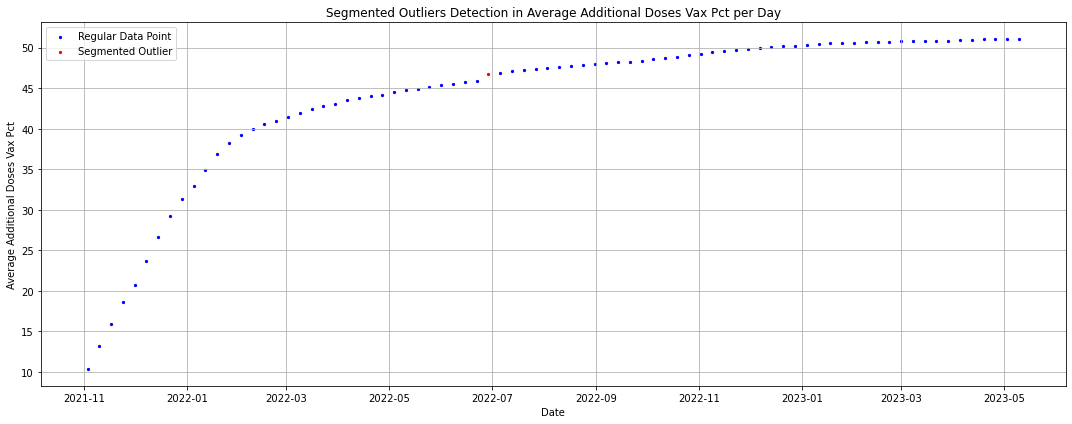

In [6]:
avg_vax_pct_per_day = df.groupby('Date')['Additional_Doses_Vax_Pct'].mean().reset_index()
# Convert 'Date' to datetime format
avg_vax_pct_per_day['Date'] = pd.to_datetime(avg_vax_pct_per_day['Date'])

# Create a month-year column for segmentation
avg_vax_pct_per_day['Month_Year'] = avg_vax_pct_per_day['Date'].dt.to_period('M')

# Group by Month_Year and calculate IQR for each month
iqr_values = avg_vax_pct_per_day.groupby('Month_Year')['Additional_Doses_Vax_Pct'].apply(lambda x: (x.quantile(0.25), x.quantile(0.75))).reset_index()
iqr_values.columns = ['Month_Year', 'IQR_Values']
iqr_values['Q1'] = iqr_values['IQR_Values'].apply(lambda x: x[0])
iqr_values['Q3'] = iqr_values['IQR_Values'].apply(lambda x: x[1])
iqr_values['Lower_Bound'] = iqr_values['Q1'] - 1.5 * (iqr_values['Q3'] - iqr_values['Q1'])
iqr_values['Upper_Bound'] = iqr_values['Q3'] + 1.5 * (iqr_values['Q3'] - iqr_values['Q1'])

# Merge the IQR values back to the main dataframe
avg_vax_pct_per_day = pd.merge(avg_vax_pct_per_day, iqr_values, on='Month_Year')

# Determine if a data point is an outlier for its respective month
avg_vax_pct_per_day['is_segmented_outlier'] = (avg_vax_pct_per_day['Additional_Doses_Vax_Pct'] < avg_vax_pct_per_day['Lower_Bound']) | (avg_vax_pct_per_day['Additional_Doses_Vax_Pct'] > avg_vax_pct_per_day['Upper_Bound'])
# Scatter plot to see segmented analysis outliers
plt.figure(figsize=(15, 6))

# Plot non-outliers in blue and outliers in red
plt.scatter(avg_vax_pct_per_day[avg_vax_pct_per_day['is_segmented_outlier'] == False]['Date'], 
            avg_vax_pct_per_day[avg_vax_pct_per_day['is_segmented_outlier'] == False]['Additional_Doses_Vax_Pct'], 
            color='blue', s=5, label='Regular Data Point')

plt.scatter(avg_vax_pct_per_day[avg_vax_pct_per_day['is_segmented_outlier'] == True]['Date'], 
            avg_vax_pct_per_day[avg_vax_pct_per_day['is_segmented_outlier'] == True]['Additional_Doses_Vax_Pct'], 
            color='red', s=5, label='Segmented Outlier')

plt.title('Segmented Outliers Detection in Average Additional Doses Vax Pct per Day')
plt.xlabel('Date')
plt.ylabel('Average Additional Doses Vax Pct')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Exploratory Data Analysis
#### Temporal Visualizations & Seasonal Decomposition:

In [7]:
# group data by date as there are multiple entires per each date
time_series_data = df.groupby('Date')[pred_var].mean().reset_index()
# set index to date
time_series_data = time_series_data.set_index('Date')

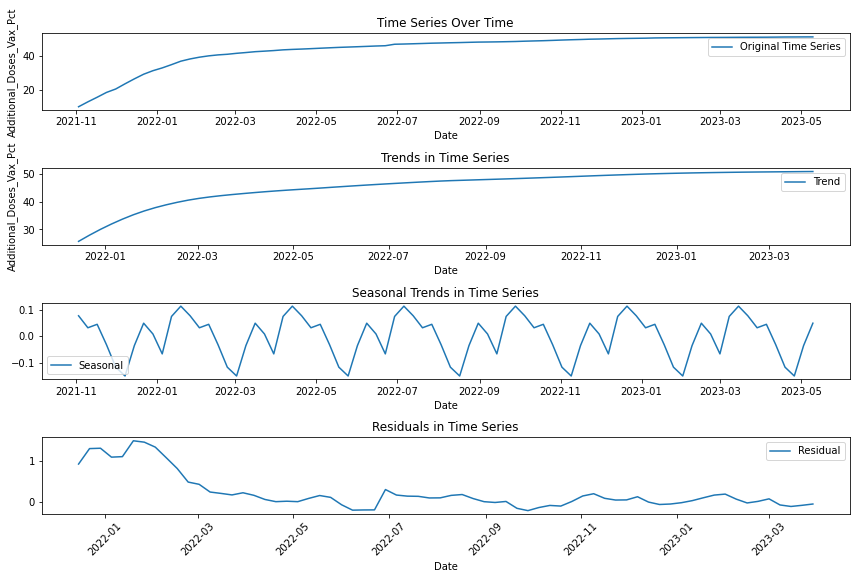

In [8]:
# STL decomposition to investigating trends, seasons and residual

import statsmodels.api as sm
import matplotlib.pyplot as plt

# Perform STL decomposition with a known seasonality period (e.g., 12 for monthly data)
result = sm.tsa.seasonal_decompose(time_series_data[pred_var], model='stl', period=12)

# Access the decomposed components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the original time series, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))

# Plot a subset of data (e.g., every 30th data point)
plt.subplot(4, 1, 1)
plt.plot(time_series_data[pred_var], label='Original Time Series')
plt.legend()
plt.title('Time Series Over Time')
plt.xlabel('Date')
plt.ylabel(pred_var)


plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()
plt.title('Trends in Time Series')
plt.xlabel('Date')
plt.ylabel(pred_var)



plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()
plt.title('Seasonal Trends in Time Series')
plt.xlabel('Date')

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend()
plt.title('Residuals in Time Series')
plt.xlabel('Date')

# Customize x-axis labels to rotate by 45 degrees
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


We have used the STL decomposition to investigate potential trends, seasons and residuals. Based on the STL plot, we have learned that `Additional Doses Vax Pct` has a very steep increase in the first 4-5 months after its initial release and then the rate has tapered and increased at a small and steady rate. This was expected as most people who wanted the booster, receved it when it first came out. The seasonal plot provides clear evidence for a seasonal pattern. This pattern is something we kept in mind and explored further in variable analysis. We will have to account for this pattern in a variety of ways moving forward with the project. For example one of the solutions is to use an ARIMA model which can account for seasonal components. However, for other models we have creaed a categorical `Season` variable. Lastly, the Residual pattern suggests that teh STL may not have adequately captured some underlying patterns or structures in our time series data. 

### Correlation Analysis:

To investigate lag we have plotted an ACF graph. The pattern the ACF plot exhibited is commonly observed in time series data with a strong short-term memory or persistence. It implied that the most recent values have a more pronounced impact on the current value, and the impact of earlier values diminishes gradually. The decay in autocorrelation suggests a relatively fast decrease in correlation with increasing time lags. To further investigate the lag we have plotted the PACF graph which showed the most significant lag at value of 1. 

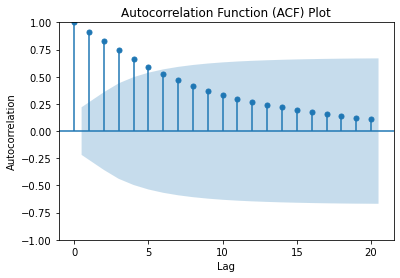

In [9]:
# ACF plot

# Create the ACF plot
plot_acf(time_series_data[pred_var])

# Customize the plot (optional)
plt.title('Autocorrelation Function (ACF) Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

# Show the plot
plt.show()

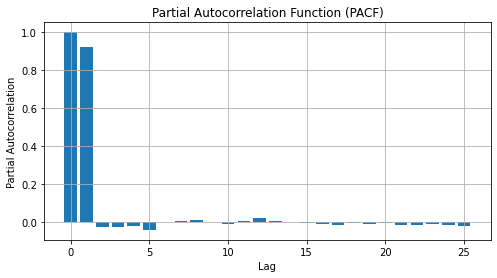

In [10]:
# PACF Plot

# Calculate the PACF
pacf = sm.tsa.pacf(time_series_data, nlags=25)

# Create the PACF plot
plt.figure(figsize=(8, 4))
plt.bar(range(len(pacf)), pacf)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True)
plt.show()

# Methodology

## ARIMA Model

### Data Preparation

For the data preparation steps for the ARIMA model, I started by grouping the data by date. This was necessary as otherwise the data contains multiple entries for each data for each state, and to predict on the country level, we had to group the data by date. You will see that I grouped by date as well for the rest of the models as well. On top of the grouping, our group decided to also scale the data using MinMaxScaler. We ran the models without scaling and with scaling, and found that scaling the data on a scale from 0 to 1 drastically improved the RMSEs for every model. This is most likely because our predictor variable maxes out at around 50-60%, and we found that putting all variables on the same scale from 0 to 1 reduced to noise of the data quite a bit. Lastly for all my models, I did a train-test split using the first reported date in 2023 as the boundary. The train dataset comprised of all observations in 2021 and 2022. The test dataset comprised of all observations in 2023. This resulted in train being 76.25% and test being 23.75% of the data.

In [2]:
# Read CSV
df = pd.read_csv('df_post_eda.csv')

# Group by date to get vaccinations at the country level
pred_var = 'Additional_Doses_Vax_Pct'
df['Date'] = pd.to_datetime(df['Date'])
df = df.groupby('Date')[pred_var].mean()
df = pd.DataFrame(df)

# Scale data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Train-Test split
split_date = '2023-01-03'
train = df_scaled[df_scaled.index < split_date]
test = df_scaled[df_scaled.index >= split_date]

#### Stationarity Analysis

In [12]:
from statsmodels.tsa.stattools import kpss

# Sample time series data (replace this with your own data)
data = df_scaled

# KPSS test
result = kpss(data, regression='c')  # 'c' for constant, 'ct' for constant with trend

# Extract test statistic and p-value 
test_statistic = result[0]
p_value = result[1]

# Compare with critical value at a chosen significance level
critical_value = 0.05  # adjust as needed
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print(f"Critical Value at 5% Significance Level: {critical_value}")

# Check the result
if test_statistic > critical_value:
    print("Reject the null hypothesis: Data is not stationary around a deterministic trend.")
else:
    print("Fail to reject the null hypothesis: Data is stationary around a deterministic trend.")

Test Statistic: 1.0632874725225505
P-value: 0.01
Critical Value at 5% Significance Level: 0.05
Reject the null hypothesis: Data is not stationary around a deterministic trend.


To check if our data is stationary, I performed the KPSS Test. The KPSS Test is useful when the non-stationarity of the data is due to a deterministic trend rather than a stochastic trend. Our data seems to be deterministic as it has a clear direction without randomness (because our predictor is a cumulative variable and not incremental). Our data also seems to follow non-stationarity, as it has an increasing trend and the mean does not remain constant over time. Our ACF graph also supports our data being non-stationary, as in stationary data, the ACF plot typically shows a rapid decay in autocorrelation as the lag increases. Our ACF graph shows a slow decline in autocorrelation as the lag increases. Thus, our data is non-stationary.

In [13]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_scaled)
print('p-value:', result[1])

result = adfuller(df_scaled.diff().dropna())
print('p-value:', result[1])

result = adfuller(df_scaled.diff().diff().dropna())
print('p-value:', result[1])

result = adfuller(df_scaled.diff().diff().diff().dropna())
print('p-value:', result[1])

p-value: 0.0013628258781567357
p-value: 0.0052358326581608905
p-value: 3.1813811354700045e-21
p-value: 7.021575729809569e-10


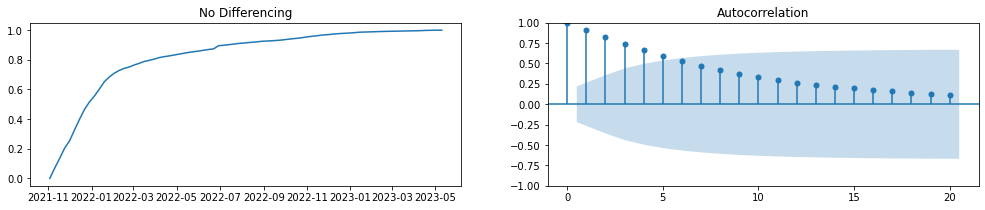

In [14]:
plt.rcParams.update({'figure.figsize':(17,3)})
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2)
axes[0].plot(df_scaled.index, df_scaled.values); axes[0].set_title('No Differencing')
axes[1].set(ylim=(0,5))
plot_acf(df_scaled.dropna(), ax=axes[1])

plt.show()

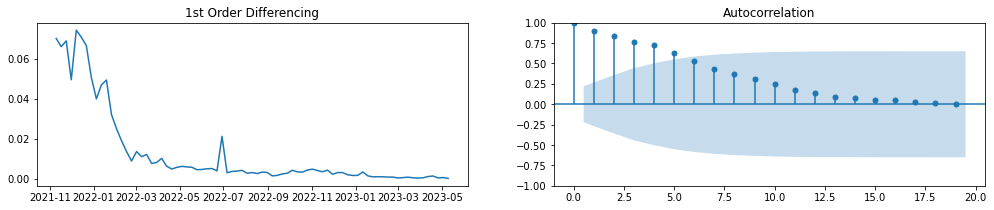

In [15]:
plt.rcParams.update({'figure.figsize':(17,3)})
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2)
axes[0].plot(df_scaled.index, df_scaled.diff().values); axes[0].set_title('1st Order Differencing')
axes[1].set(ylim=(0,5))
plot_acf(df_scaled.diff().dropna(), ax=axes[1])

plt.show()

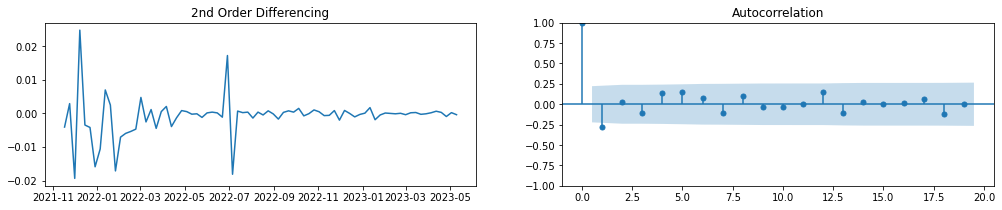

In [17]:
plt.rcParams.update({'figure.figsize':(17,3)})
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2)
axes[0].plot(df_scaled.index, df_scaled.diff().diff().values); axes[0].set_title('2nd Order Differencing')
axes[1].set(ylim=(0,5))
plot_acf(df_scaled.diff().diff().dropna(), ax=axes[1])

plt.show()

After some investigating, looking at the ADF test on the different orders of differencing, the p-value seems to go above 0.05 for the 1st order of differencing. Looking at that ACF graph for the 1st order of differencing, there is still a gradual decline in autocorrelation as lag increases, demonstrating signs of non-stationary data. Thus, looking at the graphs and the ADF test, it seems that a 2nd order of differencing enforces a stationary dataset. 

In [28]:
df_scaled = df_scaled.diff().diff().dropna()
# Train-Test split
split_date = '2023-01-03'
train = df_scaled[df_scaled.index < split_date]
test = df_scaled[df_scaled.index >= split_date]

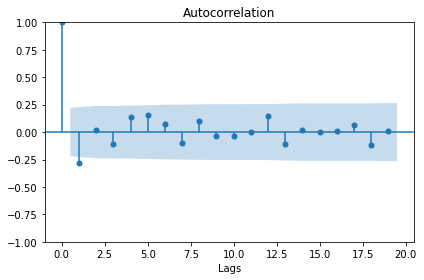

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_scaled[pred_var])
plt.xlabel('Lags')
plt.tight_layout()
plt.show()

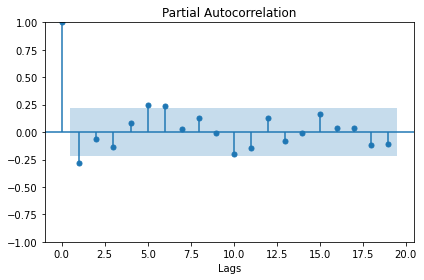

In [7]:
plot_pacf(df_scaled[pred_var])
plt.xlabel('Lags')
plt.tight_layout()
plt.show()

#### Key Parameters

The 3 parameters that define the ARIMA model are `p`, `d`, and `q` that denote the number of lagged (or past) observations to consider for autoregression, the number of times the raw observations are differenced, and the size of the moving average window respectively. ARIMA uses differencing to make the data stationary. Differencing, at its simplest, involves taking the difference of two adjacent data points. (https://www.projectpro.io/article/how-to-build-arima-model-in-python/544) As shown above, I differentiated our dataset twice already to make it stationary. Thus, we can assume values for `d` equal to 0 or greater than 0. Looking at the PACF graph on the stationary data, we can see that there is strong correlation at lag 1, thus I first looked at a `p` value of 1 for the base model. Looking at the ACF graph, we see that there is also a strong correlation at lag 1, thus I first looked at a `q` value of 1 as well (https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf#%F0%9F%9A%80-Cheat-Sheet).

### Model Building

#### Base Model

As previoiusly mentioned, I first noted that I would initially consider values of `p=1` and `q=1`. I first ran a base ARIMA model to see the baseline RMSEs of the model without any parameter tuning.

In [21]:
# Fit an ARIMA model on the training data
order = (1, 0, 1) 
model = ARIMA(train, order = order)
fit_model = model.fit()

# Make predictions on the training and testing sets
train_pred = fit_model.fittedvalues
test_pred = fit_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

# Calculate RMSE for training set
train_rmse = sqrt(mean_squared_error(train, train_pred))

# Calculate RMSE for testing set
test_rmse = sqrt(mean_squared_error(test, test_pred))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.006253853745181731
Test RMSE: 0.0012932281985915805


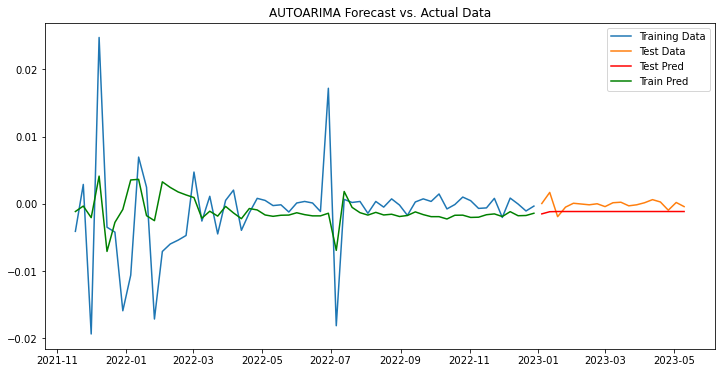

In [22]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(test.index, test_pred, label='Test Pred', color='red')
plt.plot(train.index, train_pred, label='Train Pred', color='green')
plt.legend()
plt.title('AUTOARIMA Forecast vs. Actual Data')
plt.show()

#### Tuning the Hyperparameters

From the base model, the RMSEs that returned were pretty low. The test RMSE was lower than train RMSE, indicating there not being a problem of overfitting. I started with a large grid search in the hyperparameters, considering values for `p` and `q` from 0 to 5. I still kept `d=0` because the data is already stationary. I initially ran into some problems here because I initially did walk-forward validation to tune the parameters, however, I wasn't returning desirable results. This was because walk-forward validation uses limited training data and does not involve any randomization/shuffling of data. Specifically, walk-forward validation only does one train-test split, and the model is trained on the training set and evaluated on the test set. Cross-validation involves multiple train-test splits, providing a more robust estimate of the model's performance. Thus, I used TimeSeriesSplit to introduce cross-validation in my model evaluation process, which I was able to achieve much better train and test RMSE results. 

In [23]:
# Define the range of hyperparameters for the grid search
p_values = range(0, 5)
d_values = [0]
q_values = range(0, 5)

# Perform time series cross-validation with sklearn TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size=4, gap=3)  
best_test_rmse = float('inf')
best_order = None

# Grid search through ARIMA hyperparameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            test_rmse_values = []

            for train_index, test_index in tscv.split(train):
                train_fold, test_fold = train.iloc[train_index], train.iloc[test_index]

                # Train ARIMA model
                model = ARIMA(train_fold, order=(p, d, q))
                fit_model = model.fit()

                # Make predictions on the test fold
                test_fold_pred = fit_model.predict(start=len(train_fold), end=len(train_fold)+len(test_fold)-1, dynamic=True)

                # Calculate RMSE for the test fold
                test_fold_rmse = sqrt(mean_squared_error(test_fold, test_fold_pred))
                test_rmse_values.append(test_fold_rmse)

            # Calculate average test RMSE across cross-validation folds
            avg_test_rmse = np.mean(test_rmse_values)

            # Update best order if current combination has lower average test RMSE
            if avg_test_rmse < best_test_rmse:
                best_test_rmse = avg_test_rmse
                best_order = (p, d, q)

print(f"Best ARIMA Order: {best_order}")
print(f"Lowest Average Test RMSE: {best_test_rmse}")

Best ARIMA Order: (4, 0, 3)
Lowest Average Test RMSE: 0.0015996618785064933


In [24]:
order = (4, 0, 3)  
model = ARIMA(train, order = order)
fit_model = model.fit()

train_pred = fit_model.fittedvalues
test_pred = fit_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

# Calculate RMSE for training set
train_rmse = sqrt(mean_squared_error(train, train_pred))

# Calculate RMSE for testing set
test_rmse = sqrt(mean_squared_error(test, test_pred))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.005959318467220481
Test RMSE: 0.0010846435747641902


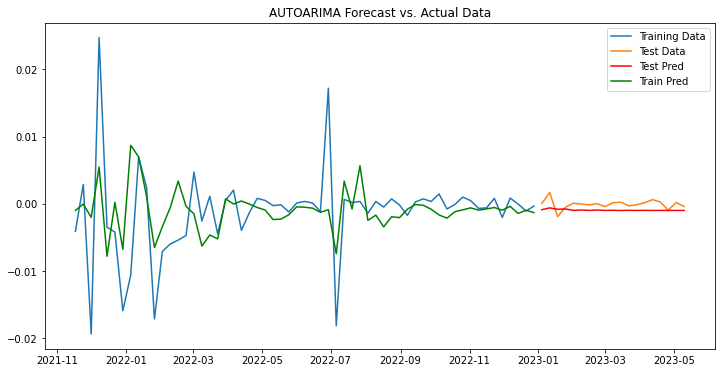

In [25]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(test.index, test_pred, label='Test Pred', color='red')
plt.plot(train.index, train_pred, label='Train Pred', color='green')
plt.legend()
plt.title('AUTOARIMA Forecast vs. Actual Data')
plt.show()

With this grid search, I got `p=4` and `q=3`, which returned fairly comparable RMSEs to the baseline model. I next decided to introduce a range of `d` from 0 to 5, so I can explore values of d greater than 0 and see if that would improve the model's performance.

In [26]:
# Define the range of hyperparameters for the grid search
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)

# Perform time series cross-validation with sklearn TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size=4, gap=3)  
best_test_rmse = float('inf')
best_order = None

# Grid search through ARIMA hyperparameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            test_rmse_values = []

            for train_index, test_index in tscv.split(train):
                train_fold, test_fold = train.iloc[train_index], train.iloc[test_index]

                # Train ARIMA model
                model = ARIMA(train_fold, order=(p, d, q))
                fit_model = model.fit()

                # Make predictions on the test fold
                test_fold_pred = fit_model.predict(start=len(train_fold), end=len(train_fold)+len(test_fold)-1, dynamic=True)

                # Calculate RMSE for the test fold
                test_fold_rmse = sqrt(mean_squared_error(test_fold, test_fold_pred))
                test_rmse_values.append(test_fold_rmse)

            # Calculate average test RMSE across cross-validation folds
            avg_test_rmse = np.mean(test_rmse_values)

            # Update best order if current combination has lower average test RMSE
            if avg_test_rmse < best_test_rmse:
                best_test_rmse = avg_test_rmse
                best_order = (p, d, q)

print(f"Best ARIMA Order: {best_order}")
print(f"Lowest Average Test RMSE: {best_test_rmse}")

Best ARIMA Order: (0, 1, 0)
Lowest Average Test RMSE: 0.000982438262758869


In [28]:
order = (0, 1, 0)  
model = ARIMA(train, order = order)
fit_model = model.fit()

train_pred = fit_model.fittedvalues
test_pred = fit_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

# Calculate RMSE for training set
train_rmse = sqrt(mean_squared_error(train, train_pred))

# Calculate RMSE for testing set
test_rmse = sqrt(mean_squared_error(test, test_pred))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.010522539979038011
Test RMSE: 0.0007269376766069217


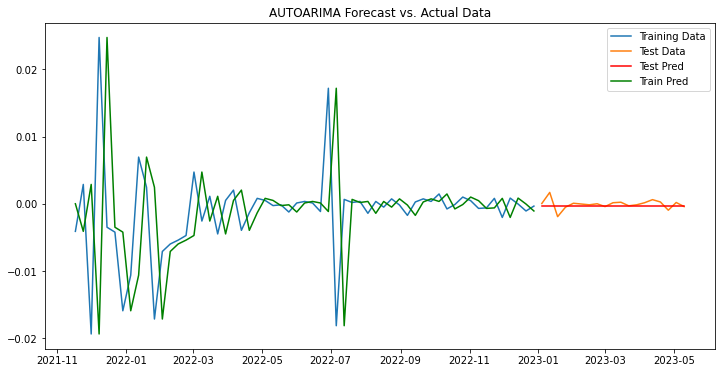

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(test.index, test_pred, label='Test Pred', color='red')
plt.plot(train.index, train_pred, label='Train Pred', color='green')
plt.legend()
plt.title('AUTOARIMA Forecast vs. Actual Data')
plt.show()

Getting `p=0`, `d=1`, and `q=0` seemed to increase the train RMSE but decrease the test RMSE. The predictions on the train and test data do seem to follow the actual data more closely than the baseline model. I believe the train RMSE is going to be higher than the test RMSE because the train data seems to have inherently much more noise than the test data. Lastly, as our PACF and ACF graph mentioned, our data seems to have values for `p=1` and `q=1`. Differentiating the data once (`d=1`) seemed to help the predictions follow the trends of both the train and test dataset better. I wanted to see what RMSEs an order of `(1,1,1)` would return. This returned a similar train RMSE to the base model but a much lower test RMSE than the base model. 

In [32]:
order = (1, 1, 1)  
model = ARIMA(train, order = order)
fit_model = model.fit()

train_pred = fit_model.fittedvalues
test_pred = fit_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

# Calculate RMSE for training set
train_rmse = sqrt(mean_squared_error(train, train_pred))

# Calculate RMSE for testing set
test_rmse = sqrt(mean_squared_error(test, test_pred))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.006843349703919045
Test RMSE: 0.0007288740567812579


### Model Performance

The best parameter values for my ARIMA model were (`1,1,1)`. This order meant 1 lag for autogregression, 1st order differencing, and 1 moving average term on our stationary data (differencing twice). As we looked at the ACF and PACF graph of our stationary data, a `p=1` and `q=1` order makes sense. Setting `d=1` on our stationary data might have been necessary for capturing certain patterns in the data. 

While this order returned a similar train RMSE to the base model and a much lower test RMSE to the base model, it is noted that the test RMSE is much lower than the train RMSE. As I mentioned before, I believe this is the nature of the differences in the train and test dataset. The train data seems to incorporate much more noise than the test data, most likely because the vaccination rate increases rapidly at the beginning of our dataset and then slows towards the end (following a logarithmic growth). Thus, the simplicity of the test data compared to our train data indicates the higher train RMSE and much lower test RMSE. 

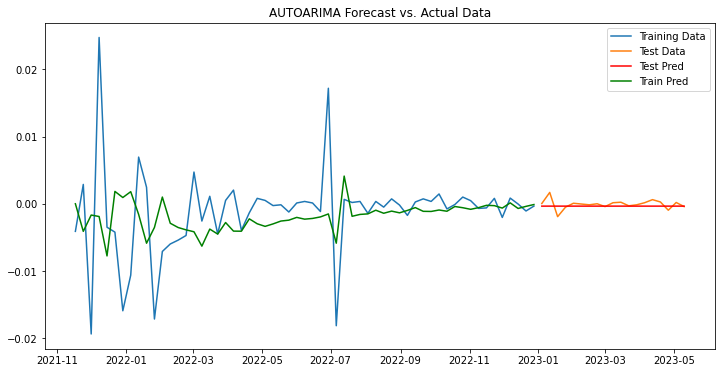

In [33]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(test.index, test_pred, label='Test Pred', color='red')
plt.plot(train.index, train_pred, label='Train Pred', color='green')
plt.legend()
plt.title('AUTOARIMA Forecast vs. Actual Data')
plt.show()

## Auto-ARIMA Model

### Data Preparation

For the Auto-ARIMA model, the data preparation was the same as the ARIMA. I did not difference the data for Auto-ARIMA because Auto-ARIMA automamtically automates the `d` parameter. I worried that if I manually differenced the data before passing it to auto_arima it could lead to over-differencing.

The key difference between Auto-ARIMA and the traditional ARIMA is the automatic selection of the model's orders. While ARIMA requires manual identification of appropriate orders, Auto-ARIMA automates this process by searching over possible combinations of orders to find the model that minimizes a chosen information criterion. Auto-ARIMA helps provide better predictions without needing to generate the values myself. The key parameters in Auto-ARIMA include `p`, `d`, and `q` which are in traditional ARIMA as well as `P`, `D`, and `Q` which are the seasonal components of `p`, `d`, and `q`. Lastly, `m` is the seasonal period which is the number of observations per season. The key parameters of Auto-ARIMA are automatically determined through a stepwise search process. 

### Model Building

    Explain the training process for the Auto_ARIMA model.
    • Discuss challenges faced during the training phase and their resolutions.
    • Concisely describe the ARIMA model's key parameters tuning and its final parameter values

To start, I ran a base model search without specifying any of the parameters except `m=12`. By running a base model without specifying many of the parameters, I let the algorithm itself determine the best seasonal order and order selection. The best model returned was `ARIMA(0,2,1)(1,0,0)[12]`. Here, I ran a SARIMAX model rather than an ARIMA model to determine the train and test RMSE based off these orders. I originally tried running an ARIMA model but learned that ARIMA assumes no seasonality, so the seasonal order specified by Auto-ARIMA were not taken into account. The results of this base model showed overfitting on the train data.

In [12]:
model = auto_arima(train, seasonal=True, m=12, 
                      suppress_warnings=True, stepwise=True,
                      error_action='warn', trace=True,
                      seasonal_order=None,   # Let the algorithm determine the optimal seasonal order
                   seasonal_test='ocsb', # Use 'ocsb' for seasonal order selection
                        random_state=45)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=-416.820, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-422.034, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=-424.844, Time=0.10 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=-424.468, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=-423.808, Time=0.04 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=-422.859, Time=0.38 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=-422.812, Time=0.11 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=-424.527, Time=0.09 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=-420.904, Time=0.35 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=-423.070, Time=0.08 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=-422.906, Time=0.16 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=-422.056, Time=0.06 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=-424.006, Time=0.07 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=-420.921, Time=0.18 sec
 ARIMA(1,2,0)(1,0,0

In [4]:
p, d, q = 0, 2, 1
P, D, Q, S = 1, 0, 0, 12

# Create and train the SARIMAX model
model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, S))
fit_model = model.fit(method='powell')

# Make predictions on the training set (fitted values)
train_pred = fit_model.fittedvalues

# Make predictions on the test set
test_pred = fit_model.get_forecast(steps=len(test))
test_pred_mean = test_pred.predicted_mean

# Calculate RMSE for training set
train_rmse = sqrt(mean_squared_error(train, train_pred))

# Calculate RMSE for test set
test_rmse = sqrt(mean_squared_error(test, test_pred_mean))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

Optimization terminated successfully.
         Current function value: -3.531121
         Iterations: 2
         Function evaluations: 122
Training RMSE: 0.010981423610464548
Testing RMSE: 0.005517790178342288


As expected, the auto-ARIMA model returned best `d=2` (Differentiating twice for ARIMA returned stationary data). I learned that setting `d=None` in Auto-ARIMA lets the model automatically select the value based on the results of the test. Auto-ARIMA works by conducting differencing tests to determine the order of differencing, d, and then fitting models within the ranges of defined start_p, max_p, start_q, and max_q ranges. A similar thing is done for the seasonal parameters. Thus, I set `d=None` and `D=None` and specified start and max parameters for `p`, `q`, `P`, and `Q`. **ADD CITATION**

In [6]:
model = auto_arima(train, seasonal=True, m=12,  
                      suppress_warnings=True, stepwise=True,
                      error_action='warn', trace=True,
                      random_state = 45,
                      start_p=0, start_q=0, max_p=5, max_q=5, 
                      start_P=0, start_Q=0, max_P=5, max_Q=5,
                      D=None, # want algorithm to determin optimal value for D
                      d=None, # want algorithm to determin optimal value for d
                      seasonal_test='ocsb',  # Use 'ocsb' for seasonal order selection
                      suppress_state_transition_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-422.034, Time=0.04 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=-424.844, Time=0.10 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=-424.468, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=-423.808, Time=0.04 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=-422.859, Time=0.43 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=-422.812, Time=0.11 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=-424.527, Time=0.11 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=-420.904, Time=0.44 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=-423.070, Time=0.08 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=-422.906, Time=0.18 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=-422.056, Time=0.07 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=-424.006, Time=0.08 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=-420.921, Time=0.21 sec
 ARIMA(1,2,0)(1,0,0)[12] intercept   : AIC=-425.204, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0

In [7]:
# Best hyperparameters
p, d, q = 0, 2, 1
P, D, Q, S = 1, 0, 0, 12

# Create and train the SARIMAX model
model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, S))
fit_model = model.fit(enforce_stationarity=False, enforce_invertibility=False, method='powell')

# Make predictions on the training set (fitted values)
train_pred = fit_model.fittedvalues

# Make predictions on the test set
test_pred = fit_model.get_forecast(steps=len(test))
test_pred_mean = test_pred.predicted_mean

# Calculate RMSE for training set
train_rmse = sqrt(mean_squared_error(train, train_pred))

# Calculate RMSE for test set
test_rmse = sqrt(mean_squared_error(test, test_pred_mean))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

Optimization terminated successfully.
         Current function value: -3.531121
         Iterations: 2
         Function evaluations: 122
Training RMSE: 0.010981423610464548
Testing RMSE: 0.005517790178342288


Letting Auto-ARIMA itself determine the best values for `d` and `D` showed that `d=2` and `D=0` were optimal for the data and returned the same parameters as the base model. The `d=2` makes sense since differentiating the dataset twice for ARIMA returned a stationary dataset. Lastly, I wanted to see if different values of `m` would change the best result. The code below shows what I did to determine the best value of `m`. The best `m` came out as `12` which was what it was specified as before. This for-loop also returned the best model as above, which was `ARIMA(0,2,1)(1,0,0)[12]`.

In [5]:
# Define a range of m values to iterate over
m_values = [1, 4, 7, 12, 24]  # Adjust this list based on your considerations

best_rmse = float('inf')
best_m = None

for m in m_values:
    model = auto_arima(train, seasonal=True, m=m,  
                      suppress_warnings=True, stepwise=True,
                      error_action='warn', trace=True,
                      random_state = 45,
                      start_p=0, start_q=0, max_p=3, max_q=3, 
                      start_P=0, start_Q=0, max_P=3, max_Q=3,
                      D=None, # want algorithm to determin optimal value for D
                      d=None, # want algorithm to determin optimal value for d
                      seasonal_test='ocsb',  # Use 'ocsb' for seasonal order selection
                      suppress_state_transition_warnings=True)
    
    # Make predictions on the test set
    test_predictions = model.predict(len(test))
    
    # Calculate RMSE for the current m value
    rmse = sqrt(mean_squared_error(test, test_predictions))
    
    # Update the best m if the current m performs better
    if rmse < best_rmse:
        best_rmse = rmse
        best_m = m

print('Best Model Test RMSE:', best_rmse)
print('Best Model m:', best_m)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-422.034, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-423.808, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-423.754, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-421.822, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-421.799, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-419.835, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-424.874, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-421.845, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-423.152, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-423.335, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-425.399, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-423.399, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-413.370, Time=0.04 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 0.532 seconds
Performing stepwise se

 ARIMA(0,2,1)(0,0,1)[24] intercept   : AIC=-423.399, Time=0.44 sec
 ARIMA(0,2,1)(1,0,1)[24] intercept   : AIC=-421.397, Time=0.50 sec
 ARIMA(0,2,2)(0,0,0)[24] intercept   : AIC=-423.399, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[24] intercept   : AIC=-413.370, Time=0.05 sec

Best model:  ARIMA(0,2,1)(0,0,0)[24] intercept
Total fit time: 4.891 seconds
Best Model Test RMSE: 0.0845601255764781
Best Model m: 12


Lastly, I wanted to do cross-validation for Auto-ARIMA to find the best model parameters. The code below is an automated approach to find the best SARIMAX model order parameters using time series cross-validation, where the model is trained and evaluated on different subsets of the time series data. I first created a TimeSeriesSplit object with 5 splits, a test set size of 4, and a gap of 3 between train and test sets. I then iterate through the time series splits where each split extracts training and test sets, I then use the Auto-ARIMA function to automatically search for the best SARIMAX model order parameters. It then fits a SARIMAX model using the best order parameters found in the previous step, and then makes predictions on the test set using the fitted SARIMAX model. It then calculates the test RMSE and then updates the best order parameters and seasonal order parameters if the current test RMSE is lower than the previous test RMSE. 

In [20]:
tscv = TimeSeriesSplit(n_splits=5, test_size=4, gap=3)

# Initialize variables to store the best model parameters and lowest RMSE
best_order = None
best_rmse = float('inf')

# Iterate through the time series splits
for train_index, test_index in tscv.split(train):
    train_data, test_data = train.iloc[train_index], train.iloc[test_index]

    # Use auto_arima to find the best order parameters
    model = auto_arima(train_data, start_p=0, start_q=0, max_p=5, max_q=5, m=12,
                           start_P=0, start_Q=0, max_P=5, max_Q=5, seasonal=True, 
                           d=2, D =0, trace=True,
                        error_action='ignore', suppress_warnings=True, stepwise=False)
    order = model.get_params()['order']
    seasonal_order = model.get_params()['seasonal_order']

    # Train SARIMAX model with the best order parameters
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    arima_fit = model.fit(enforce_stationarity=False, enforce_invertibility=False, method='powell')

    # Make predictions on the test set
    predictions = arima_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, typ='levels')

    # Calculate RMSE for the test set
    rmse = np.sqrt(mean_squared_error(test_data, predictions))

    # Update best parameters if current RMSE is lower
    if rmse < best_rmse:
        best_rmse = rmse
        best_order = order
        best_seasonal_order = seasonal_order

# Print the best order parameters and the corresponding RMSE
print(f"Best Order Parameters: {best_order}")
print(f"Best Seasonal Order Parameters: {best_seasonal_order}")
print(f"Lowest Test RMSE: {best_rmse}")

 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-239.201, Time=0.04 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=-239.450, Time=0.06 sec
 ARIMA(0,2,0)(0,0,2)[12]             : AIC=-235.201, Time=0.10 sec
 ARIMA(0,2,0)(0,0,3)[12]             : AIC=-235.558, Time=3.62 sec
 ARIMA(0,2,0)(0,0,4)[12]             : AIC=-233.564, Time=2.41 sec
 ARIMA(0,2,0)(0,0,5)[12]             : AIC=-231.564, Time=2.33 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=-239.543, Time=0.09 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=-237.637, Time=0.08 sec
 ARIMA(0,2,0)(1,0,2)[12]             : AIC=-235.643, Time=0.37 sec
 ARIMA(0,2,0)(1,0,3)[12]             : AIC=-233.643, Time=5.43 sec
 ARIMA(0,2,0)(1,0,4)[12]             : AIC=-231.643, Time=4.08 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=-237.585, Time=0.37 sec
 ARIMA(0,2,0)(2,0,1)[12]             : AIC=-235.643, Time=0.43 sec
 ARIMA(0,2,0)(2,0,2)[12]             : AIC=-233.643, Time=0.55 sec
 ARIMA(0,2,0)(2,0,3)[12]             : AIC=-231.632, Time=1.99

 ARIMA(4,2,0)(1,0,0)[12]             : AIC=-235.105, Time=0.19 sec
 ARIMA(4,2,1)(0,0,0)[12]             : AIC=-235.283, Time=0.10 sec
 ARIMA(5,2,0)(0,0,0)[12]             : AIC=-236.553, Time=0.10 sec

Best model:  ARIMA(0,2,4)(0,0,0)[12]          
Total fit time: 124.307 seconds
Optimization terminated successfully.
         Current function value: -3.307230
         Iterations: 7
         Function evaluations: 504
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-270.177, Time=0.02 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=-268.178, Time=0.05 sec
 ARIMA(0,2,0)(0,0,2)[12]             : AIC=-269.001, Time=0.31 sec
 ARIMA(0,2,0)(0,0,3)[12]             : AIC=-267.126, Time=2.99 sec
 ARIMA(0,2,0)(0,0,4)[12]             : AIC=-265.121, Time=4.21 sec
 ARIMA(0,2,0)(0,0,5)[12]             : AIC=-263.111, Time=5.50 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=-271.010, Time=0.07 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=-267.555, Time=0.18 sec
 ARIMA(0,2,0)(1,0,2)[12]             : AIC=-

 ARIMA(3,2,1)(1,0,0)[12]             : AIC=-265.637, Time=0.17 sec
 ARIMA(3,2,2)(0,0,0)[12]             : AIC=-263.156, Time=0.09 sec
 ARIMA(4,2,0)(0,0,0)[12]             : AIC=-266.161, Time=0.05 sec
 ARIMA(4,2,0)(0,0,1)[12]             : AIC=-265.676, Time=0.13 sec
 ARIMA(4,2,0)(1,0,0)[12]             : AIC=-266.288, Time=0.16 sec
 ARIMA(4,2,1)(0,0,0)[12]             : AIC=-265.842, Time=0.11 sec
 ARIMA(5,2,0)(0,0,0)[12]             : AIC=-267.350, Time=0.11 sec

Best model:  ARIMA(0,2,4)(0,0,0)[12]          
Total fit time: 141.448 seconds
Optimization terminated successfully.
         Current function value: -3.368012
         Iterations: 8
         Function evaluations: 622
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-301.527, Time=0.04 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=-299.528, Time=0.05 sec
 ARIMA(0,2,0)(0,0,2)[12]             : AIC=-300.864, Time=0.30 sec
 ARIMA(0,2,0)(0,0,3)[12]             : AIC=-295.527, Time=0.37 sec
 ARIMA(0,2,0)(0,0,4)[12]             : AIC=-

 ARIMA(3,2,0)(0,0,2)[12]             : AIC=-297.600, Time=0.69 sec
 ARIMA(3,2,0)(1,0,0)[12]             : AIC=-298.898, Time=0.07 sec
 ARIMA(3,2,0)(1,0,1)[12]             : AIC=-297.418, Time=0.17 sec
 ARIMA(3,2,0)(2,0,0)[12]             : AIC=-297.894, Time=0.97 sec
 ARIMA(3,2,1)(0,0,0)[12]             : AIC=-296.513, Time=0.04 sec
 ARIMA(3,2,1)(0,0,1)[12]             : AIC=-297.209, Time=0.19 sec
 ARIMA(3,2,1)(1,0,0)[12]             : AIC=-296.718, Time=0.13 sec
 ARIMA(3,2,2)(0,0,0)[12]             : AIC=-294.607, Time=0.10 sec
 ARIMA(4,2,0)(0,0,0)[12]             : AIC=-298.105, Time=0.09 sec
 ARIMA(4,2,0)(0,0,1)[12]             : AIC=-298.186, Time=0.20 sec
 ARIMA(4,2,0)(1,0,0)[12]             : AIC=-298.435, Time=0.15 sec
 ARIMA(4,2,1)(0,0,0)[12]             : AIC=-296.472, Time=0.09 sec
 ARIMA(5,2,0)(0,0,0)[12]             : AIC=-299.310, Time=0.10 sec

Best model:  ARIMA(0,2,4)(0,0,0)[12]          
Total fit time: 153.100 seconds
Optimization terminated successfully.
         Cu

 ARIMA(2,2,1)(2,0,0)[12]             : AIC=-328.578, Time=0.70 sec
 ARIMA(2,2,2)(0,0,0)[12]             : AIC=-328.316, Time=0.09 sec
 ARIMA(2,2,2)(0,0,1)[12]             : AIC=-328.514, Time=0.33 sec
 ARIMA(2,2,2)(1,0,0)[12]             : AIC=-328.612, Time=0.20 sec
 ARIMA(2,2,3)(0,0,0)[12]             : AIC=-326.874, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[12]             : AIC=-330.707, Time=0.03 sec
 ARIMA(3,2,0)(0,0,1)[12]             : AIC=-330.756, Time=0.16 sec
 ARIMA(3,2,0)(0,0,2)[12]             : AIC=-328.976, Time=0.95 sec
 ARIMA(3,2,0)(1,0,0)[12]             : AIC=-330.441, Time=0.05 sec
 ARIMA(3,2,0)(1,0,1)[12]             : AIC=-328.905, Time=0.18 sec
 ARIMA(3,2,0)(2,0,0)[12]             : AIC=-328.258, Time=0.57 sec
 ARIMA(3,2,1)(0,0,0)[12]             : AIC=-328.498, Time=0.03 sec
 ARIMA(3,2,1)(0,0,1)[12]             : AIC=-328.664, Time=0.20 sec
 ARIMA(3,2,1)(1,0,0)[12]             : AIC=-328.245, Time=0.15 sec
 ARIMA(3,2,2)(0,0,0)[12]             : AIC=-326.558, Time=0.12

 ARIMA(2,2,0)(3,0,0)[12]             : AIC=-361.067, Time=2.85 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=-362.635, Time=0.06 sec
 ARIMA(2,2,1)(0,0,1)[12]             : AIC=-363.043, Time=0.21 sec
 ARIMA(2,2,1)(0,0,2)[12]             : AIC=-361.193, Time=0.91 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=-362.848, Time=0.10 sec
 ARIMA(2,2,1)(1,0,1)[12]             : AIC=-361.192, Time=0.18 sec
 ARIMA(2,2,1)(2,0,0)[12]             : AIC=-360.733, Time=0.46 sec
 ARIMA(2,2,2)(0,0,0)[12]             : AIC=-360.640, Time=0.09 sec
 ARIMA(2,2,2)(0,0,1)[12]             : AIC=-359.285, Time=0.14 sec
 ARIMA(2,2,2)(1,0,0)[12]             : AIC=-361.167, Time=0.13 sec
 ARIMA(2,2,3)(0,0,0)[12]             : AIC=-362.149, Time=0.10 sec
 ARIMA(3,2,0)(0,0,0)[12]             : AIC=-363.060, Time=0.03 sec
 ARIMA(3,2,0)(0,0,1)[12]             : AIC=-363.260, Time=0.25 sec
 ARIMA(3,2,0)(0,0,2)[12]             : AIC=-361.599, Time=0.76 sec
 ARIMA(3,2,0)(1,0,0)[12]             : AIC=-362.950, Time=0.08

### Model Performance

The best model was proven to be `ARIMA(0,2,4)(0,0,0)[12]`. The performance of this model can be seen below. In comparison to my ARIMA model, the Auto-ARIMA model has higher train and test RMSEs than the ARIMA model. This could be because the data is not differenced in the Auto-ARIMA model like it was in the ARIMA model. Similarly, the Auto-ARIMA does seem to have a smaller difference between the train and test RMSEs in comparison to the ARIMA model, most likely because the ARIMA model train data had a lot more noise than the un-differenced Auto-ARIMA train data. 

I think another thing that caused this difference was the model selection criteria. For the ARIMA models, a grid search was done over possible `p`, `d`, and `q` values and the model that returned the lowest test RMSE was selected. For Auto-ARIMA, the "best" model was chosen based on different information criteria (AIC). Also, as noted above, auto-ARIMA helps define seasonal parameters which the ARIMA models do not take into account. 

I think lastly, the difference could've been caused because Auto-ARIMA determines the best value of differencing (`d` and `D`) before then determining the best other parameters. This order was not done when doing the grid-search for ARIMA. 

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Best hyperparameters
p, d, q = 0, 2, 4
P, D, Q, S = 0, 0, 0, 12

# Create and train the SARIMAX model
model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, S))
fit_model = model.fit(enforce_stationarity=False, enforce_invertibility=False, method='powell')

# Make predictions on the training set (fitted values)
train_pred = fit_model.fittedvalues

# Make predictions on the test set
test_pred = fit_model.get_forecast(steps=len(test))
test_pred_mean = test_pred.predicted_mean

# Calculate RMSE for training set
train_rmse = sqrt(mean_squared_error(train, train_pred))

# Calculate RMSE for test set
test_rmse = sqrt(mean_squared_error(test, test_pred_mean))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

Optimization terminated successfully.
         Current function value: -3.598686
         Iterations: 8
         Function evaluations: 530
Training RMSE: 0.010786948432851143
Testing RMSE: 0.007496154177013731


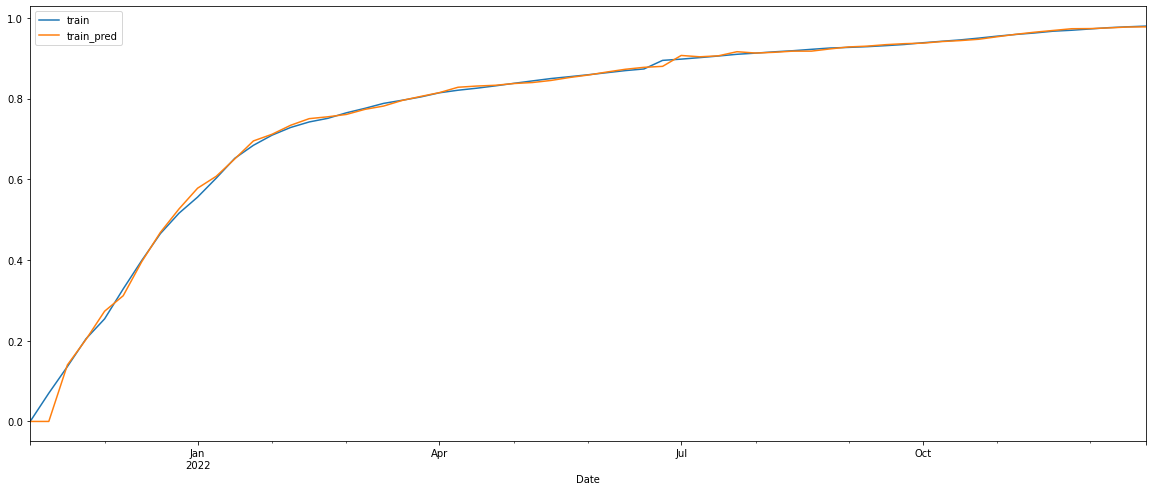

In [23]:
pd.concat([train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train', 'train_pred'])

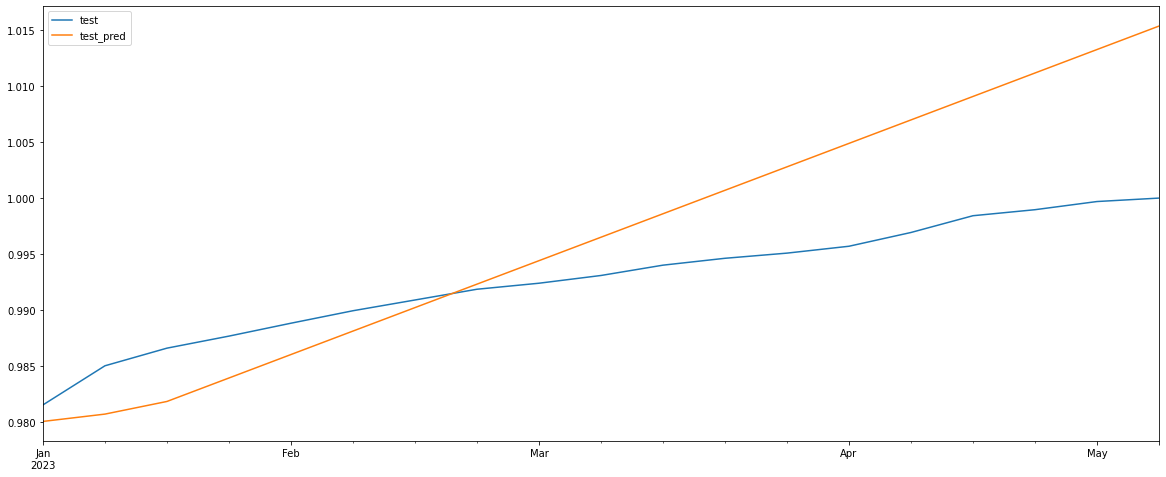

In [24]:
pd.concat([test, test_pred_mean], axis=1).plot(figsize=(20, 8))
plt.legend(['test', 'test_pred'])

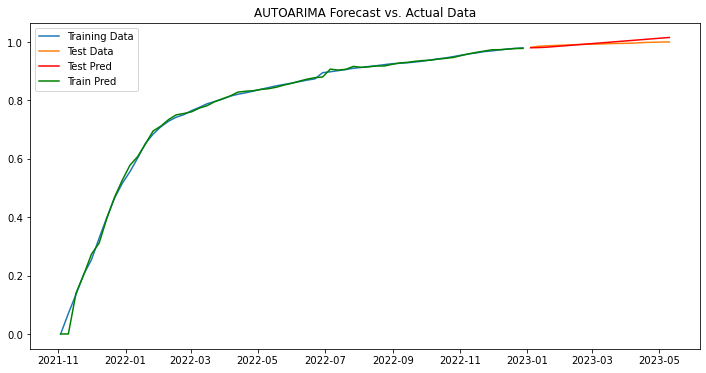

In [25]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(test.index, test_pred_mean, label='Test Pred', color='red')
plt.plot(train.index, train_pred, label='Train Pred', color='green')
plt.legend()
plt.title('AUTOARIMA Forecast vs. Actual Data')
plt.show()

## Prophet Univariate Model

### Data Preparation

Prophet is an effective model at handling time series with multiple seasonalities. It also captures holidays and events, making it suitable for datasets with irregular patterns. Prophet decomposes time series into trend, seasonal, and holiday components, providing a clear and intuitive representation of the underlying patterns in the data. 

Key parameters of the Prophet model are `changepoint_prior_scale` which controls the flexibility of the changepoints (where significant shifts or changes occur in the time series), `seasonality_prior_scale` which controls the strength of the seasonal components, `holidays_prior_scale` which controls the impact of holidays, and `seasonality_mode` which defines how seasonality is modeled (options included `additive` and `multiplicative`). Higher values of `changepoint_prior_scale` make the trend more flexible. Higher values of `seasonality_prior_scale` and `holidays_prior_scale` allow more flexibility iin capturing seasonality and holiday effects.

Much of the data preparation I did for the Prophet models were similar to what I did for the ARIMA models and the rest of the models in this report. I grouped the data by date so we can predict the vaccination rate on the country level and have 1 unique value per date. I also scaled the data the same way as the ARIMA models. A little differently, I decided to remove the seasonality features that we created in the feature enginerring section. This is because Prophet automatically incorporates seasonality patterns. These steps were in preparation for the Prophet Multivariate model. For the Prophet Univariate model, the date column must be renamed as `ds` and the predictor variable as `y`, in which I did in this step. I did the same train-test split as the ARIMA models.

In [16]:
# Read csv
df = pd.read_csv('df_post_eda.csv')

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

grouped = df.groupby(df.index).mean()

pred_var = 'Additional_Doses_Vax_Pct'

# Dropping Unncessary Columns
columns_to_drop = ['MMWR_week', 'month', 'year', 'quarter', 'dayofyear', 'dayofmonth', 'weekofyear', 'Additional_Doses_Vax_Pct_1_w_lag']
df = grouped.drop(columns=columns_to_drop)

# Scale data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Subsetting to Date and Predictor -> making Prophet (Univariate) dataframe
df_single = df_scaled.groupby(df_scaled.index)[pred_var].mean()
df_single = pd.DataFrame(df_single)
df_single.reset_index(level=0, inplace=True)
df_single = df_single.rename(columns={'Date': 'ds', 'Additional_Doses_Vax_Pct': 'y'})

split_date = '2023-01-03'

train = df_single[df_single['ds'] < split_date]
test = df_single[df_single['ds'] >= split_date]

### Model Building

Prophet models take into account different trend factors, where you can specify a piecewise linear model (default) or logistic growth model. This was an input into the model that I was unaware of. For much of the initial modelling of my Prophet models, I kept the default linear model. While I achieved comparable RMSEs to the other models, I dealt with much more overfitting than I did when I set `growth='logistic'`. This is because our predictor variable seems to follow more closely a logistic growth than linear growth, resulting in much less overfitting to the training data. Below shows baseline Prophet models I ran with the two different trend factors. As you can see, setting `growth='logistic'` seemed to increase the baseline RMSEs in comparison to the default linear model. However, the baseline Prophet model with `growth='logistic'` appeared to have no overfitting issues. After much trial and error with the two trend factors, I decided to continue setting parameter `growth='logistic'` to avoid overfitting and aimed to reduce the RMSE through parameter tuning.

#### Default Linear Growth Model

In [65]:
# Create a Prophet model
model = Prophet()

# Fit the model on the training data
model.fit(train)

# Make predictions on the training set
train_predictions = model.predict(train)

# Make predictions on the test set
test_predictions = model.predict(test)

# Extract the actual and predicted values
train_actual = train['y']
test_actual = test['y']

train_pred = train_predictions['yhat']
test_pred = test_predictions['yhat']

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

15:15:49 - cmdstanpy - INFO - Chain [1] start processing
15:15:49 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 0.0028713622193601443
Test RMSE: 0.029572437335438392


#### `Growth = 'Logistic'`

In [68]:
train['cap'] = 1
test['cap'] = 1

# Create a Prophet model
model = Prophet(growth='logistic')

# Fit the model on the training data
model.fit(train)
 
# Make predictions on the training set
train_predictions = model.predict(train)

# Make predictions on the test set
test_predictions = model.predict(test)

# Extract the actual and predicted values
train_actual = train['y']
test_actual = test['y']

train_pred = train_predictions['yhat']
test_pred = test_predictions['yhat']

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

15:18:04 - cmdstanpy - INFO - Chain [1] start processing
15:18:04 - cmdstanpy - INFO - Chain [1] done processing


Training RMSE: 0.24794113726182446
Testing RMSE: 0.24414838647504167


Prophet models allow you to include additional regressor variables to improve the accuracy of the forecasts. For instance, you can add a holiday component and a seasonality compenent to the Prophet model. 

First, I tried adding US holidays to the model. However, doing this actually resulted in no actual change in the baseline train and test RMSE. After some research, I learned that this was because our data has been aggregated to a weekly frequency. Holidays that don't fall on the particluar date in our dataset will be ignored. Because our dataset is only Wednesdays, all of the US Holidays were ignored and the holidays had no impact in the model. We have feature engineered a Holiday boolean column that I dropped for the Univariate Prophet model, but I do include in the Prophet Multivariate model. 

Next, you can specify `seasonality_mode` to `'multiplicative'` or `'additivite'` (default). I attempted to set `seasonality_mode = 'multiplicative'`, however once again, this did not change the baseline RMSEs. This means our seasonality is relatively `additive` and that the seasonal variation in our data is relatively constant over time which can be seen in the seasonal decomposition section above.

#### Holiday Component

In [69]:
# Create a Prophet model
model = Prophet(growth='logistic')
model.add_country_holidays(country_name='US')

# Fit the model on the training data
model.fit(train)

# Make predictions on the training set
train_predictions = model.predict(train)

# Make predictions on the test set
test_predictions = model.predict(test)

# Extract the actual and predicted values
train_actual = train['y']
test_actual = test['y']

train_pred = train_predictions['yhat']
test_pred = test_predictions['yhat']

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

15:24:22 - cmdstanpy - INFO - Chain [1] start processing
15:24:23 - cmdstanpy - INFO - Chain [1] done processing


Training RMSE: 0.24794113990148273
Testing RMSE: 0.2441478284340313


#### Seasonality Component

In [70]:
# Create a Prophet model
model = Prophet(growth='logistic', seasonality_mode='multiplicative')

# Fit the model on the training data
model.fit(train)

# Make predictions on the training set
train_predictions = model.predict(train)

# Make predictions on the test set
test_predictions = model.predict(test)

# Extract the actual and predicted values
train_actual = train['y']
test_actual = test['y']

train_pred = train_predictions['yhat']
test_pred = test_predictions['yhat']

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

15:25:48 - cmdstanpy - INFO - Chain [1] start processing
15:25:48 - cmdstanpy - INFO - Chain [1] done processing


Training RMSE: 0.24794113726182446
Testing RMSE: 0.24414838647504167


#### Tuning Cross Validation

Prophet has a `cross_validation()` function that allows for time series cross validation to measure forecast error using historical data. This is done by specifying a forecast `horizon` within the training dataset, then specifying an `initial` training period, and spacing between cutoff periods (`period`). After some trial and error, I learned that chaning the specifications of these 3 parameters actually returned different best parameters. Thus I tuned, the `horizion`, `initial`, and `period` parameters to determine which to use on my training data that would return the best RMSEs. The code for that grid search is below (I didn't run in this file for the sake of runtime). The best parameters for the cross validation function were `{'horizon': 7, 'initial': 49, 'period': 7}`.

In [ ]:
from sklearn.model_selection import ParameterSampler
from sklearn.model_selection import ParameterGrid

param_grid = {
    'initial': list(range(49, 210, 7)),  
    'period': [7, 14] ,  
    'horizon': [7, 14] 
}

all_params = list(ParameterGrid(param_grid))

best_rmse = float('inf')
best_params = None

for params in all_params:
    model = Prophet(growth='logistic').fit(train)
    horizon = f'{params["horizon"]} days'
    initial = f'{params["initial"]} days'
    period = f'{params["period"]} days'
    
    df_cv = cross_validation(model, horizon=horizon, initial=initial, period=period)

    metrics = performance_metrics(df_cv)
    rmse = metrics['rmse'].mean()
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

#### Tuning Model Hyperparameters 

Lastly, I tuned 4 hyperparameters: `changepoint_prior_scale`, `seasonality_prior_scale`, `holidays_prior_scale`, and `seasonality_mode` (which I already determined should return `additive`). The grid search I did is below (I didn't run again in this file because of the runtime), and the best parameters were `{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}`

In [ ]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'growth': ['logistic']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, parallel="processes", initial='49 days', period='7 days', horizon='7 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

### Model Performance

Using the parameters listed above from my grid search I ran my final Prophet Univariate model. The final train and test RMSE are below. As you can see, the train and test RMSE have decreased significantly from the baseline Prophet model. Also additionally, I was able to reduce the overfitting problem by setting `growth='logistic'` in which the test RMSE is smaller than the train RMSE. 

The final parameter of `changepoint_prior_scale` returned `0.5`, which was the highest provided in the list. The higher value memans the model is made to be moderately flexible in capturing changes in the trend. In addition, `seasonality_prior_scale` and `holidays_prior_scale` returned values of 0.01, the lowest provided in the search list. This means the model forced strong regularization to both seasonality and holiday effects in the data. 

Overall the Prophet Univariate model returned farily good RMSEs in comparison to the other models. Specifically for this model, the test predictions followed the trend of the actual test data the most closely.

In [71]:
# Tuned model
tuned_model = Prophet(growth='logistic', changepoint_prior_scale = 0.5, seasonality_prior_scale = 0.01, 
                     holidays_prior_scale = 0.01, seasonality_mode = 'additive')

# Fit the model on the training data
tuned_model.fit(train)

# Make predictions on the training set
train_predictions = tuned_model.predict(train)

# Make predictions on the test set
test_predictions = tuned_model.predict(test)

# Extract the actual and predicted values
train_actual = train['y']
test_actual = test['y']

train_pred = train_predictions['yhat']
test_pred = test_predictions['yhat']

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

15:41:46 - cmdstanpy - INFO - Chain [1] start processing
15:41:46 - cmdstanpy - INFO - Chain [1] done processing


Training RMSE: 0.01073493701326449
Testing RMSE: 0.009585945963442762


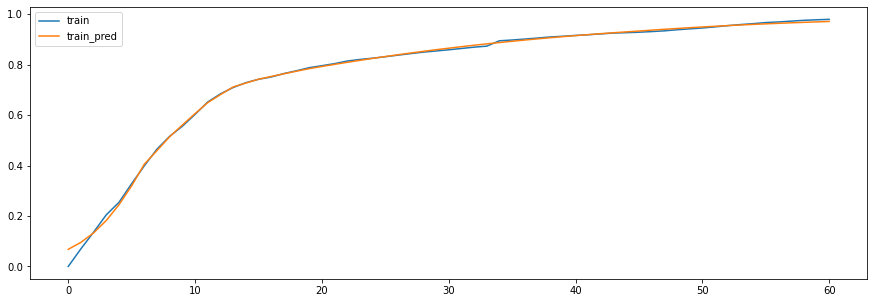

In [72]:
# Plot the training predictions
pd.concat([train['y'], train_predictions['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

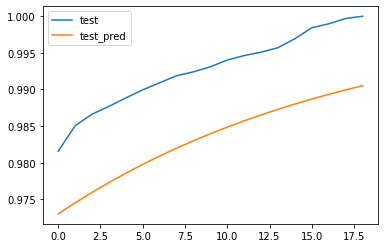

In [73]:
pd.concat([test.reset_index()['y'],test_predictions['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

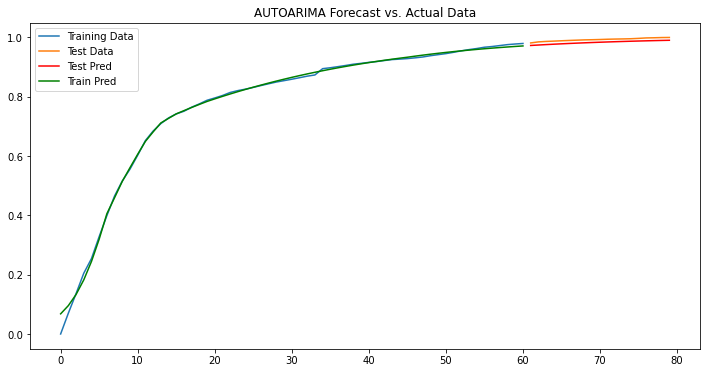

In [80]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train['y'], label='Training Data')
plt.plot(test['y'], label='Test Data')
plt.plot(test.index, test_predictions['yhat'], label='Test Pred', color='red')
plt.plot(train.index, train_predictions['yhat'], label='Train Pred', color='green')
plt.legend()
plt.title('AUTOARIMA Forecast vs. Actual Data')
plt.show()

## Prophet Multivariate Model

### Data Preparation

The base of my Prophet Multivariate Model was the scaled dataframe from the Prophet Univariate Model. In this dataframe, `holiday_season` (holiday boolean column we created during feature engineering) and `vax_announcement` (boolean column that =1 if a vaccine announcement occured during that week) were kept to capture these trends. I decided to lag all the columns in our dataset because our PACF graph showed that a lag of 1 was the most significant. I decided not to lag `holiday_season` and `vax_announcement` as shifting those by a week did not seem to make sense (making Christmas season occur a week later). Prophet doesn't provide explicit feature importance metrics like some machine learning models do. The reason is that Prophet relies on a specific additive time series decomposition, and the contribution of each feature is intertwined with the overall time series decomposition. Thus, all columns in the dataset were includiing the Prophet Multivariate Model. Lastly, the date column must be renamed as ds and the predictor variable as y, in which I did in this step. I did the same train-test split as the all the prior models.

In [20]:
def process(df, columns_to_exclude=['holiday_season', 'vax_announcement']):
    columns_to_lag = [col for col in df.columns if col not in columns_to_exclude]
    lag1df = df[columns_to_lag].shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df=df[['Additional_Doses_Vax_Pct', 'holiday_season', 'vax_announcement']].join(lag1df)
    return df.fillna(0) 
df = process(df_scaled)
df.reset_index(inplace=True)

df_multiple = df.rename(columns={'Date': 'ds', 'Additional_Doses_Vax_Pct': 'y'})

split_date = '2023-01-03'

train_multiple = df_multiple[df_multiple['ds'] < split_date]
test_multiple = df_multiple[df_multiple['ds'] >= split_date]

train_multiple['cap'] = 1
test_multiple['cap'] = 1

### Model Building

Many of the same steps I took in the training process for the Prophet Multivariate model were similar to the Prophet Univariate model. First I ran a base model with all regressors added (still initializing `growth='logistic'`). This base model indicated incredibly strong overfitting to the training data.

In [21]:
# Create a Prophet model
model = Prophet(growth='logistic')
for col in train_multiple.columns:
    if col not in ['ds', 'y', 'cap']:
        model.add_regressor(col)
        
# Fit the model on the training data
model.fit(train_multiple)

# Make predictions on the training set
train_predictions = model.predict(train_multiple)

# Make predictions on the test set
test_predictions = model.predict(test_multiple)

# Extract the actual and predicted values
train_actual = train_multiple['y']
test_actual = test_multiple['y']

train_pred = train_predictions['yhat']
test_pred = test_predictions['yhat']

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

17:36:03 - cmdstanpy - INFO - Chain [1] start processing
17:36:27 - cmdstanpy - INFO - Chain [1] done processing


Training RMSE: 2.8390193665674756e-05
Testing RMSE: 32.71007611133216


Thus, I played around with initializing some of the parameters to see if that would reduce the overfitting. I played with `changepoint_prior_scale`, `seasonality_prior_scale`, etc. However, only setting `holidays_prior_scale = 0.01` seemed to reduce the initial overfitting significantly. There is still slight overfitting but nothing to the scale of the first base model. This seems to indicate that our model was overly sensitive to holiday-related fluctuations. 

In [22]:
# seems to be overfitting the training data -> adjust changepoint_prior_scale/sesonality_prior_scale/holidays_prior_scale
# Create a Prophet model
model = Prophet(growth='logistic', holidays_prior_scale = 0.01)
for col in train_multiple.columns:
    if col not in ['ds', 'y', 'cap']:
        model.add_regressor(col)
        
# Fit the model on the training data
model.fit(train_multiple)

# Make predictions on the training set
train_predictions = model.predict(train_multiple)

# Make predictions on the test set
test_predictions = model.predict(test_multiple)

# Extract the actual and predicted values
train_actual = train_multiple['y']
test_actual = test_multiple['y']

train_pred = train_predictions['yhat']
test_pred = test_predictions['yhat']

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

17:38:39 - cmdstanpy - INFO - Chain [1] start processing
17:38:41 - cmdstanpy - INFO - Chain [1] done processing


Training RMSE: 0.004887093755051402
Testing RMSE: 0.005336567529287136


The following steps were very similar to the Prophet Univariate Model. I tuned the `cross_validation()` function to find the best `horizion`, `initial`, and `period` parameters. I then used those `cross_validation()` parameters in a grid search to find the best model hyperparameters. The code below for those 2 tunings are below but for the sake of runtime were not ran in this file.

In [ ]:
param_grid = {
    'initial': list(range(7, 245, 7)), 
    'period': [7, 14] ,  
    'horizon': [7, 14] 
}

n_iter = 15

best_rmse = float('inf')
best_params = None

for params in ParameterSampler(param_distributions=param_grid, n_iter=n_iter, random_state=42):
    model = Prophet(growth='logistic', holidays_prior_scale = 0.01)
    for col in train_multiple.columns:
        if col not in ['ds', 'y', 'cap']:
            model.add_regressor(col)   
    model.fit(train_multiple)
    horizon = f'{params["horizon"]} days'
    initial = f'{params["initial"]} days'
    period = f'{params["period"]} days'
    
    df_cv = cross_validation(model, horizon=horizon, initial=initial, period=period)

    metrics = performance_metrics(df_cv)
    rmse = metrics['rmse'].mean()
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

In [ ]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01],
    'seasonality_mode': ['additive', 'multiplicative'],
    'growth': ['logistic']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    model = Prophet(**params)
    for col in train_multiple.columns:
        if col not in ['ds', 'y', 'cap']:
            model.add_regressor(col)   
    model.fit(train_multiple)
    df_cv = cross_validation(model, parallel="processes", initial='133 days', period='7 days', horizon='7 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

### Model Performance

The best `cross_validation()` parameters were `{'period': 7, 'initial': 133, 'horizon': 7}`. The best model hyperparameters were `{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}`. The model hyperparameters were the same as the Prophet Univariate model. For the Prophet Multivariate model, the test RMSE is slightly higher than the train RMSE, which indicates overfitting (more overfitting than the base model itself). The Multivariate model seems to return lower RMSES than the Univariate model, but seems to introduce more overfitting than the Univariate model. This could be because the Multivariate Prophet model might be more flexible due to the inclusion of additional variables, making it capable of capturing more complex patterns in the training data. While increased flexibility can lead to better fitting of the training data, it may result in overfitting if the model captures noise that doesn't generalize well to new, unseen data.

In [23]:
tuned_model = Prophet(changepoint_prior_scale = 0.5, seasonality_prior_scale = 0.01, 
                     holidays_prior_scale = 0.01, seasonality_mode = 'additive', growth='logistic')
for col in train_multiple.columns:
    if col not in ['ds', 'y', 'cap']:
        tuned_model.add_regressor(col)
        
# Fit the model on the training data
tuned_model.fit(train_multiple)

# Make predictions on the training set
train_predictions = tuned_model.predict(train_multiple)

# Make predictions on the test set
test_predictions = tuned_model.predict(test_multiple)

# Extract the actual and predicted values
train_actual = train_multiple['y']
test_actual = test_multiple['y']

train_pred = train_predictions['yhat']
test_pred = test_predictions['yhat']

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

17:43:19 - cmdstanpy - INFO - Chain [1] start processing
17:43:21 - cmdstanpy - INFO - Chain [1] done processing


Training RMSE: 0.001610876823343092
Testing RMSE: 0.007704756966457684


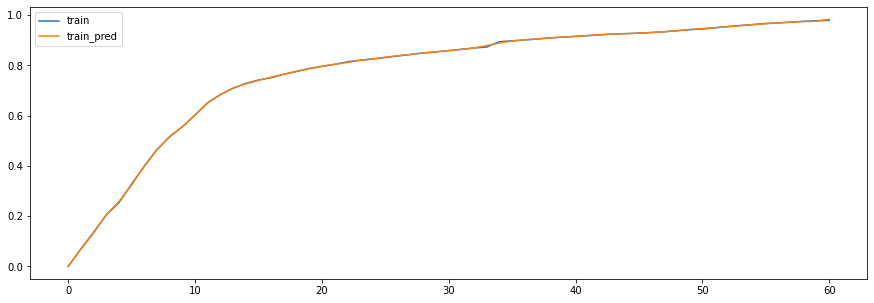

In [24]:
# Plot the training predictions
pd.concat([train_multiple['y'], train_predictions['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

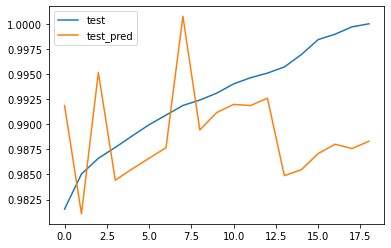

In [25]:
pd.concat([test_multiple.reset_index()['y'],test_predictions['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

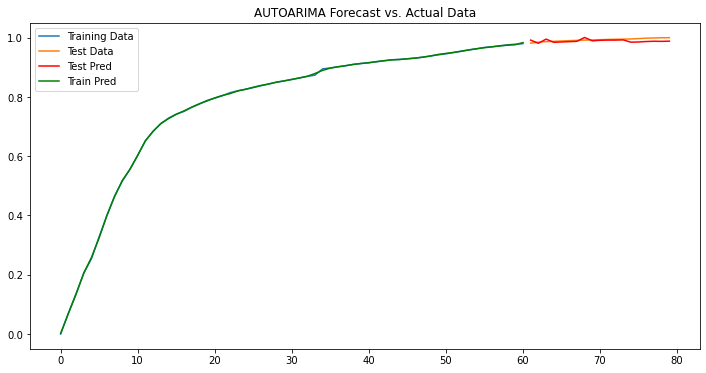

In [26]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_multiple['y'], label='Training Data')
plt.plot(test_multiple['y'], label='Test Data')
plt.plot(test_multiple.index, test_predictions['yhat'], label='Test Pred', color='red')
plt.plot(train_multiple.index, train_predictions['yhat'], label='Train Pred', color='green')
plt.legend()
plt.title('AUTOARIMA Forecast vs. Actual Data')
plt.show()

## XGBoost

# Conclusion & Next Steps


Overall the EDA and data processing we have performed so far allowed us to gain a lot of inisght into our data.
Our next goal is to start developing different prediction models. For time series forcasting model we will use the grouped by `Date` data. One of the first models we will develop is ARIMA, which we know is suitable for our stationary data and through tuning it will account for any trend patterns in the prediction variable over time. There is also possibility of using the ARIMAX model which takes into accoutn other selected features.  We will also start working on other prediction models such as Random Forest and Boosting Models (XGBoost etc.) For these models that we will be using the ungrouped data and will have to perform further investigation into the correlation between prediction variable and other features.

# References

Abulkhair, A. (2023, June 13). Data Imputation Demystified | Time Series Data | by Ahmed Abulkhair. Medium. Retrieved October 25, 2023, from https://medium.com/@aaabulkhair/data-imputation-demystified-time-series-data-69bc9c798cb7

Hahn, S. (n.d.). COVID-19 Vaccines. FDA. Retrieved October 25, 2023, from https://www.fda.gov/emergency-preparedness-and-response/coronavirus-disease-2019-covid-19/covid-19-vaccines

Kates, J., Tolbert, J., & Rouw, A. (2021, December 8). An Update on Vaccine Roll-Out for 5-11 Year-olds in the U.S. KFF. Retrieved October 25, 2023, from https://www.kff.org/coronavirus-covid-19/issue-brief/an-update-on-vaccine-roll-out-for-5-11-year-olds-in-the-u-s/

Montel, M. (2017). holidays · PyPI. PyPI. Retrieved October 25, 2023, from https://pypi.org/project/holidays/


https://www.projectpro.io/article/how-to-build-arima-model-in-python/544

https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html